<a href="https://colab.research.google.com/github/NethmiAmasha/Edge-Detection-with-Mamba/blob/main/EDMB_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("cuda available:", torch.cuda.is_available())
print("torch:", torch.__version__)
print("cuda device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

cuda available: True
torch: 2.8.0+cu126
cuda device: Tesla T4


In [ ]:
!pip install -q torch torchvision

In [ ]:
!pip install -q tqdm opencv-python matplotlib pillow scipy

In [ ]:
!pip install -q git+https://github.com/Dao-AILab/causal-conv1d@v1.1.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 26.4 MB/s eta 0:00:00


High Resolution Encoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HighResEncoder(nn.Module):
    """
    Minimal high-resolution encoder (Eh).
    Produces two feature maps:
      - f1: same spatial resolution as input (useful for edges)
      - f2: half resolution (downsampled)
    """
    def __init__(self, in_ch=3, base_ch=16):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, kernel_size=3, stride=2, padding=1),  # downsamples by 2
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        # small extra conv to produce a refined same-res feature from upsampled low-res
        self.refine = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # x: (B,3,H,W)
        f1 = self.conv1(x)               # (B, base_ch, H, W)
        f2 = self.conv2(f1)              # (B, base_ch*2, H/2, W/2)
        # upsample f2 back to input resolution and refine
        f2_up = F.interpolate(f2, size=f1.shape[-2:], mode='bilinear', align_corners=False)
        f2_refined = self.refine(f2_up)  # (B, base_ch, H, W)
        return [f1, f2_refined]

# Quick shape test
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HighResEncoder(in_ch=3, base_ch=16).to(device)
    x = torch.randn(2,3,320,320).to(device)   # batch of 2, 320x320 images
    feats = model(x)
    print("f1 shape:", feats[0].shape)
    print("f2_refined shape:", feats[1].shape)

f1 shape: torch.Size([2, 16, 320, 320])
f2_refined shape: torch.Size([2, 16, 320, 320])


Global Mamba Encoder (Eg) and Fine-grained Mamba Encoder (Ef)

In [2]:
# Simplified MIXENC (Global + Fine-grained encoders)
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNEncoder(nn.Module):
    """A lightweight CNN that returns 3 feature maps at different scales."""
    def __init__(self, in_ch=3, base_ch=32):
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, 1, 1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, 2, 1),  # downsample by 2
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.stage3 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1),  # downsample by 4
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f1 = self.stage1(x)  # (B, base_ch, H, W)
        f2 = self.stage2(f1) # (B, base_ch*2, H/2, W/2)
        f3 = self.stage3(f2) # (B, base_ch*4, H/4, W/4)
        return [f1, f2, f3]

class MIXENC_Light(nn.Module):
    """
    Simplified version of MIXENC (global + local encoders).
    Mimics structure of Eg (global) + Ef (fine-grained).
    """
    def __init__(self, base_ch=32):
        super().__init__()
        self.global_encoder = SimpleCNNEncoder(in_ch=3, base_ch=base_ch)
        self.local_encoder = SimpleCNNEncoder(in_ch=3, base_ch=base_ch)

    def cat_patch(self, f00, f01, f10, f11, target_size):
        """Stitch 4 patches back together and resize to match global feature size."""
        top = torch.cat([f00, f01], dim=3)
        bottom = torch.cat([f10, f11], dim=3)
        combined = torch.cat([top, bottom], dim=2)
        combined = F.interpolate(combined, size=target_size, mode='bilinear', align_corners=False)
        return combined

    def forward(self, x):
        """
        Returns:
          global_feats: list of feature maps from global encoder
          local_feats: list of patch-fused feature maps
        """
        # Global features
        global_feats = self.global_encoder(x)

        # Prepare local patches
        _, _, H, W = x.shape
        x_up = F.interpolate(x, scale_factor=1.2, mode='bilinear', align_corners=False)
        _, _, H2, W2 = x_up.shape
        h_mid, w_mid = H2 // 2, W2 // 2

        patches = [
            x_up[..., :h_mid, :w_mid],   # top-left
            x_up[..., :h_mid, w_mid:],   # top-right
            x_up[..., h_mid:, :w_mid],   # bottom-left
            x_up[..., h_mid:, w_mid:]    # bottom-right
        ]

        # Extract local features for each patch
        local_feats_per_patch = [self.local_encoder(p) for p in patches]  # list of 4 lists

        # Merge patch features layer-wise
        local_feats = []
        for i in range(len(global_feats)):
            f00, f01, f10, f11 = local_feats_per_patch[0][i], local_feats_per_patch[1][i], local_feats_per_patch[2][i], local_feats_per_patch[3][i]
            merged = self.cat_patch(f00, f01, f10, f11, target_size=global_feats[i].shape[2:])
            local_feats.append(merged)

        return global_feats, local_feats

# Test with random input
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MIXENC_Light(base_ch=32).to(device)
x = torch.randn(1, 3, 320, 320).to(device)

global_feats, local_feats = model(x)
for i, (g, l) in enumerate(zip(global_feats, local_feats)):
    print(f"Level {i+1}: global {g.shape}, local {l.shape}")

Level 1: global torch.Size([1, 32, 320, 320]), local torch.Size([1, 32, 320, 320])
Level 2: global torch.Size([1, 64, 160, 160]), local torch.Size([1, 64, 160, 160])
Level 3: global torch.Size([1, 128, 80, 80]), local torch.Size([1, 128, 80, 80])


In [3]:
# High-resolution encoder (Eh)
model_Eh = HighResEncoder(in_ch=3, base_ch=16).to(device)

# Combined Global + Fine-grained encoder (Eg + Ef)
model_MIX = MIXENC_Light(base_ch=32).to(device)

In [4]:
# Test both encoders and print feature shapes
with torch.no_grad():
    x = torch.randn(1, 3, 320, 320).to(device)
    f_high = model_Eh(x)
    g_global, g_local = model_MIX(x)

print("Eh outputs:")
for i, f in enumerate(f_high):
    print(f"  f{i+1}: {list(f.shape)}")

print("\nEg/Ef outputs (local_feats):")
for i, f in enumerate(g_local):
    print(f"  level{i+1}: {list(f.shape)}")

Eh outputs:
  f1: [1, 16, 320, 320]
  f2: [1, 16, 320, 320]

Eg/Ef outputs (local_feats):
  level1: [1, 32, 320, 320]
  level2: [1, 64, 160, 160]
  level3: [1, 128, 80, 80]


Learnable Gaussian Distribution Decoder

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LGDDecoder_Light(nn.Module):
    """
    Simplified Learnable Gaussian Distribution (LGD) decoder.
    Fuses high-res (Eh) and global (Eg/Ef) features.
    Outputs mu, sigma², and an auxiliary edge map.
    """
    def __init__(self, in_ch_high=16, in_ch_global=128, mid_ch=64):
        super().__init__()
        # Fuse features from Eh and Eg/Ef
        self.fuse = nn.Sequential(
            nn.Conv2d(in_ch_high + in_ch_global, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True)
        )
        # Output heads
        self.mu_head = nn.Conv2d(mid_ch, 1, kernel_size=1)      # mean
        self.var_head = nn.Sequential(                          # variance (>=0)
            nn.Conv2d(mid_ch, 1, kernel_size=1),
            nn.Softplus()
        )
        self.edge_head = nn.Conv2d(mid_ch, 1, kernel_size=1)    # auxiliary edge map

    def forward(self, f_high, f_global):
        # Upsample global feature to match high-res size
        f_global_up = F.interpolate(f_global, size=f_high.shape[-2:], mode='bilinear', align_corners=False)
        fused = torch.cat([f_high, f_global_up], dim=1)
        x = self.fuse(fused)
        mu = self.mu_head(x)
        sigma2 = self.var_head(x)
        edge_logits = self.edge_head(x)
        return mu, sigma2, edge_logits

# Test with random features
device = "cuda" if torch.cuda.is_available() else "cpu"
decoder = LGDDecoder_Light(in_ch_high=16, in_ch_global=128, mid_ch=64).to(device)

# fake inputs from encoders
f_high = torch.randn(1, 16, 320, 320).to(device)
f_global = torch.randn(1, 128, 80, 80).to(device)

mu, sigma2, edge_logits = decoder(f_high, f_global)
print("mu:", mu.shape, "sigma2:", sigma2.shape, "edge_logits:", edge_logits.shape)
print("sigma2 min/max:", sigma2.min().item(), sigma2.max().item())

mu: torch.Size([1, 1, 320, 320]) sigma2: torch.Size([1, 1, 320, 320]) edge_logits: torch.Size([1, 1, 320, 320])
sigma2 min/max: 0.17215017974376678 1.8095552921295166


Loss Function

In [6]:
import torch
import torch.nn.functional as F

def elbo_loss(mu, sigma2, y, phi=1.0, lambda_pos=1.1):
    """
    mu, sigma2 : model outputs, shape [B,1,H,W]
    y          : ground truth edges (0/1), same shape
    phi        : weight for KL term
    lambda_pos : positive class weight (for edge pixels)
    """
    # Sample from Gaussian N(mu, sigma2)
    eps = torch.randn_like(mu)
    p = mu + eps * torch.sqrt(sigma2 + 1e-6)  # reparam trick
    p = torch.sigmoid(p)  # edge probability 0-1

    # Weighted BCE
    pos = (y == 1).float()
    neg = (y == 0).float()
    total = y.numel()
    pos_count = pos.sum().clamp_min(1.0)
    neg_count = neg.sum().clamp_min(1.0)
    alpha = pos_count / total
    beta = lambda_pos * (neg_count / total)
    wce = -(alpha * (pos * torch.log(p + 1e-8)).sum() +
            beta * (neg * torch.log(1 - p + 1e-8)).sum()) / total

    # KL divergence
    kl = 0.5 * ((mu ** 2 + sigma2 - torch.log(sigma2 + 1e-8) - 1).sum()) / total

    elbo = wce + phi * kl
    return elbo, wce, kl

In [ ]:
# Fake outputs and ground truth
mu = torch.randn(1, 1, 320, 320)
sigma2 = torch.abs(torch.randn(1, 1, 320, 320))  # positive
y = (torch.rand(1, 1, 320, 320) > 0.8).float()   # random binary mask

elbo, wce, kl = elbo_loss(mu, sigma2, y)
print(f"ELBO: {elbo.item():.5f} | WCE: {wce.item():.5f} | KL: {kl.item():.5f}")

ELBO: 1.37420 | WCE: 0.65727 | KL: 0.71693


Checking with a fake batch

In [7]:
# End-to-end forward + ELBO test
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Put models in train mode so gradients exist (backward check)
model_Eh.train()
model_MIX.train()
decoder.train()

# Create a small fake batch
B = 2
x = torch.randn(B, 3, 320, 320).to(device)
# fake ground truth edges: sparse random edges
y = (torch.rand(B, 1, 320, 320) > 0.95).float().to(device)

# Forward: encoders
f_high = model_Eh(x)
g_global, g_local = model_MIX(x)

# Choose which global feature to feed to decoder:
f_global_for_decoder = g_local[-1]  # shape [B, 128, 80, 80]

# Use f_high[1] (refined high-res) as the high-res input
f_high_for_decoder = f_high[1]     # shape [B, 16, 320, 320]

# Decoder forward
mu, sigma2, edge_logits = decoder(f_high_for_decoder, f_global_for_decoder)

# Compute ELBO (phi=1.0)
elbo, wce, kl = elbo_loss(mu, sigma2, y, phi=1.0, lambda_pos=1.1)

print("Shapes:")
print(" x:", x.shape)
print(" f_high:", [tuple(t.shape) for t in f_high])
print(" g_local:", [tuple(t.shape) for t in g_local])
print(" mu:", mu.shape, "sigma2:", sigma2.shape, "edge_logits:", edge_logits.shape)
print()
print(f"ELBO: {elbo.item():.5f} | WCE: {wce.item():.5f} | KL: {kl.item():.5f}")

# Backward check: gradients should flow to decoder parameters
elbo.backward()
print()
print("Gradients (sample):")
for name, p in list(decoder.named_parameters())[:6]:
    if p.grad is None:
        print(f"  {name}: grad None")
    else:
        print(f"  {name}: grad mean {p.grad.mean().item():.6e}, std {p.grad.std().item():.6e}")

for name, p in model_Eh.named_parameters():
    print(f"Eh param {name}: requires_grad={p.requires_grad}, grad is {'present' if p.grad is not None else 'None'}")
    break

Shapes:
 x: torch.Size([2, 3, 320, 320])
 f_high: [(2, 16, 320, 320), (2, 16, 320, 320)]
 g_local: [(2, 32, 320, 320), (2, 64, 160, 160), (2, 128, 80, 80)]
 mu: torch.Size([2, 1, 320, 320]) sigma2: torch.Size([2, 1, 320, 320]) edge_logits: torch.Size([2, 1, 320, 320])

ELBO: 0.93467 | WCE: 0.84118 | KL: 0.09349

Gradients (sample):
  fuse.0.weight: grad mean -2.844281e-05, std 1.038200e-03
  fuse.0.bias: grad mean -1.207923e-10, std 1.028293e-09
  fuse.1.weight: grad mean 3.611858e-07, std 1.276727e-03
  fuse.1.bias: grad mean 6.307290e-05, std 8.225121e-04
  fuse.3.weight: grad mean 5.491826e-05, std 2.038037e-03
  fuse.3.bias: grad mean -9.038104e-11, std 4.274995e-09
Eh param conv1.0.weight: requires_grad=True, grad is present


Loading the dataset

In [8]:
!git clone https://github.com/BIDS/BSDS500.git
!mv BSDS500/BSDS500/data .

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380 (from 1)
Receiving objects: 100% (2380/2380), 155.21 MiB | 36.19 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.


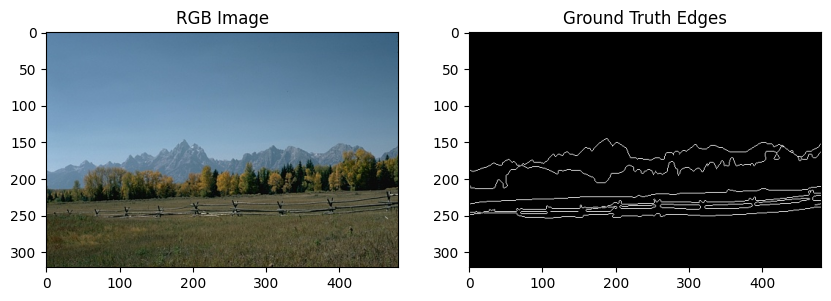

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# pick one training sample
img_path = "data/images/train/2092.jpg"
gt_path = "data/groundTruth/train/2092.mat"

# load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# load ground truth edges
mat = loadmat(gt_path)
edges_list = mat['groundTruth'][0]
# Extract the first annotator
gt_struct = edges_list[0][0, 0]  # access the MATLAB struct
edge_map = gt_struct['Boundaries']  # binary edge mask
edge_map = edge_map.astype(np.float32)

# visualize
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("RGB Image")

plt.subplot(1,2,2)
plt.imshow(edge_map, cmap='gray')
plt.title("Ground Truth Edges")
plt.show()

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
import torch
import random
import os

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', size=(320, 320)):
        """
        root_dir: path to 'data' folder (containing images/ and groundTruth/)
        split: 'train', 'val', or 'test'
        """
        self.img_dir = os.path.join(root_dir, 'images', split)
        self.gt_dir = os.path.join(root_dir, 'groundTruth', split)
        self.size = size

        self.image_files = sorted([
            f for f in os.listdir(self.img_dir) if f.endswith('.jpg')
        ])

        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize(size, interpolation=Image.BILINEAR)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        gt_path = os.path.join(self.gt_dir, img_name.replace('.jpg', '.mat'))

        # load RGB image
        img = Image.open(img_path).convert('RGB')
        img = self.resize(img)
        img = self.to_tensor(img)

        # load ground truth edge map
        mat = loadmat(gt_path)
        edges_list = mat['groundTruth'][0]
        gt_struct = edges_list[0][0, 0]
        edge_map = gt_struct['Boundaries']
        edge = Image.fromarray((edge_map * 255).astype('uint8')).convert('L')
        edge = self.resize(edge)
        edge = self.to_tensor(edge)
        edge = (edge > 0.2).float()  # binarize

        # flip for augmentation
        if random.random() < 0.5:
            img = torch.flip(img, dims=[2])  # horizontal
            edge = torch.flip(edge, dims=[2])

        return img, edge

torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


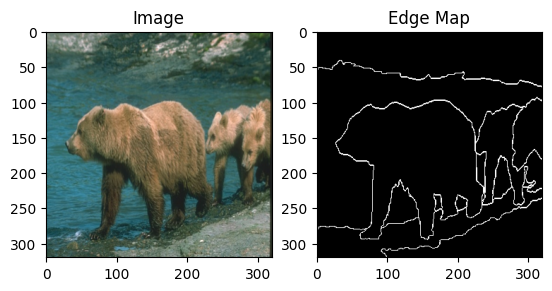

In [ ]:
dataset = BSDS500Dataset(root_dir='data', split='train')
img, edge = dataset[0]
print(img.shape, edge.shape)
plt.subplot(1,2,1); plt.imshow(img.permute(1,2,0)); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(edge[0], cmap='gray'); plt.title('Edge Map')
plt.show()

Test Training

In [11]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 2
lr = 1e-4
epochs = 3
phi = 1.0   # KL weighting

# DataLoader
train_dataset = BSDS500Dataset(root_dir='data', split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Move models to device
model_Eh.to(device)
model_MIX.to(device)
decoder.to(device)

# Optimizer (train decoder + Eh)
params = list(model_Eh.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, (imgs, edges) in enumerate(train_loader):
        imgs, edges = imgs.to(device), edges.to(device)

        optimizer.zero_grad()

        # forward
        f_high = model_Eh(imgs)
        g_global, g_local = model_MIX(imgs)
        mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])

        # compute loss
        elbo, wce, kl = elbo_loss(mu, sigma2, edges, phi=phi)
        elbo.backward()
        optimizer.step()

        running_loss += elbo.item()

        if (i+1) % 5 == 0:
            print(f"[Epoch {epoch+1}] Step {i+1}/{len(train_loader)} - "
                  f"ELBO: {elbo.item():.4f}, WCE: {wce.item():.4f}, KL: {kl.item():.4f}")

        if i == 9:  # 10 batches
            break

    print(f"Epoch {epoch+1} done. Avg loss over 10 batches: {running_loss/10:.4f}")

[Epoch 1] Step 5/100 - ELBO: 0.9156, WCE: 0.8589, KL: 0.0567
[Epoch 1] Step 10/100 - ELBO: 0.8635, WCE: 0.8195, KL: 0.0440
Epoch 1 done. Avg loss over 10 batches: 0.9010
[Epoch 2] Step 5/100 - ELBO: 0.8324, WCE: 0.7900, KL: 0.0423
[Epoch 2] Step 10/100 - ELBO: 0.8186, WCE: 0.7786, KL: 0.0400
Epoch 2 done. Avg loss over 10 batches: 0.8314
[Epoch 3] Step 5/100 - ELBO: 0.7906, WCE: 0.7508, KL: 0.0398
[Epoch 3] Step 10/100 - ELBO: 0.7674, WCE: 0.7296, KL: 0.0379
Epoch 3 done. Avg loss over 10 batches: 0.7996


Visualize predicted edge maps during training

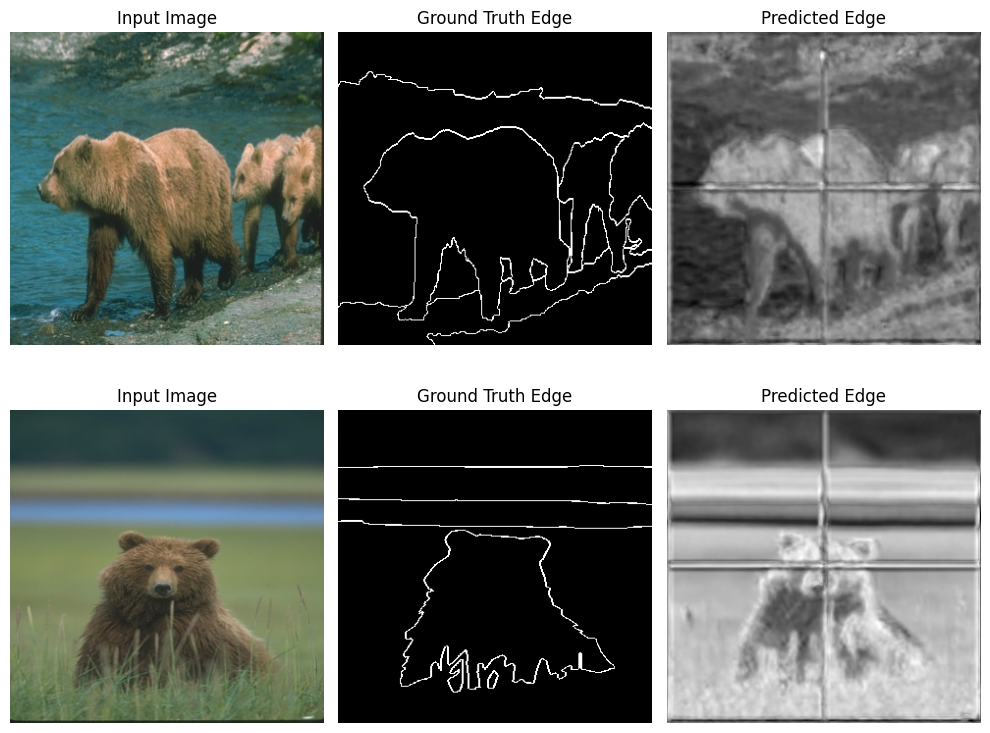

In [12]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_predictions(model_Eh, model_MIX, decoder, dataset, num_samples=2):
    model_Eh.eval()
    model_MIX.eval()
    decoder.eval()

    plt.figure(figsize=(10, 4 * num_samples))

    for i in range(num_samples):
        img, edge_gt = dataset[i]
        img = img.unsqueeze(0).to(device)
        edge_gt = edge_gt.squeeze().cpu().numpy()

        with torch.no_grad():
            f_high = model_Eh(img)
            g_global, g_local = model_MIX(img)
            mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])
            pred = torch.sigmoid(edge_logits).squeeze().cpu().numpy()

        # Display
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(img[0].permute(1, 2, 0).cpu())
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(edge_gt, cmap='gray')
        plt.title("Ground Truth Edge")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Edge")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization on a few samples
visualize_predictions(model_Eh, model_MIX, decoder, train_dataset, num_samples=2)

Multi-Granularity Edge Generation

In [13]:
def generate_multigranularity_edges(mu, sigma2, gammas=[-2, 0, 2]):
    """
    Generate edge maps for multiple γ values.
    mu, sigma2: model outputs (B,1,H,W)
    gammas: list of γ multipliers
    Returns: dict {γ: edge_map}
    """
    edges = {}
    for g in gammas:
        p = mu + g * torch.sqrt(sigma2 + 1e-6)
        p = torch.sigmoid(p)
        edges[g] = p.squeeze().cpu().numpy()
    return edges

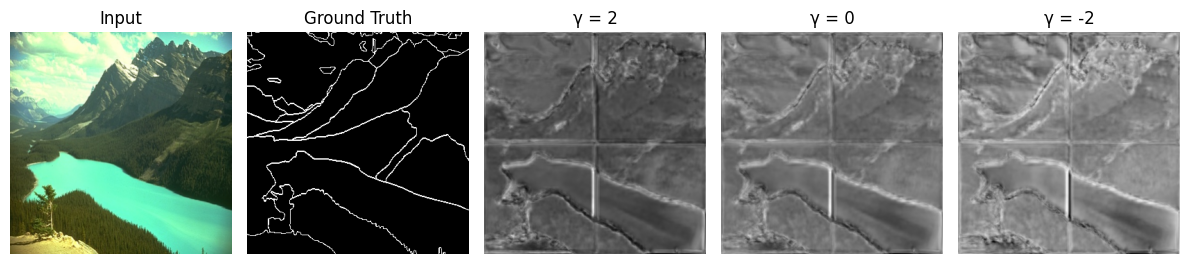

In [15]:
def visualize_multigranularity(model_Eh, model_MIX, decoder, dataset, gammas=[-2, 0, 2]):
    model_Eh.eval()
    model_MIX.eval()
    decoder.eval()

    img, edge_gt = dataset[60]  # pick one example
    img_in = img.unsqueeze(0).to(device)

    with torch.no_grad():
        f_high = model_Eh(img_in)
        g_global, g_local = model_MIX(img_in)
        mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])
        multi_edges = generate_multigranularity_edges(mu, sigma2, gammas)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, len(gammas)+2, 1)
    plt.imshow(img.permute(1,2,0))
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, len(gammas)+2, 2)
    plt.imshow(edge_gt.squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    for j, g in enumerate(gammas):
        plt.subplot(1, len(gammas)+2, j+3)
        plt.imshow(multi_edges[g], cmap="gray")
        plt.title(f"γ = {-g}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# visualization
visualize_multigranularity(model_Eh, model_MIX, decoder, train_dataset, gammas=[-2, 0, 2])

Cross-Feature Fusion (CFF)

In [ ]:
# Multi-scale CFF + LGD decoder (improved)
import torch
import torch.nn as nn
import torch.nn.functional as F

# CFF block: fuse two feature maps
class CFFBlock(nn.Module):
    """
    Cross-Feature Fusion block: fuse two feature tensors (a and b) possibly different channels.
    Uses 1x1 conv to match channels, then attention-like gating and conv refinement.
    """
    def __init__(self, in_a, in_b, out_ch):
        super().__init__()
        self.match_a = nn.Conv2d(in_a, out_ch, 1)
        self.match_b = nn.Conv2d(in_b, out_ch, 1)
        # gating
        self.gate = nn.Sequential(
            nn.Conv2d(out_ch * 2, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.Sigmoid()
        )
        # refinement convs
        self.refine = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, a, b):
        # a, b: tensors with shapes (B, Ca, H, W) and (B, Cb, H, W)
        A = self.match_a(a)
        B = self.match_b(b)
        cat = torch.cat([A, B], dim=1)
        g = self.gate(cat)
        fused = A * g + B * (1 - g)
        out = self.refine(fused)
        return out

# Multi-scale LGD decoder that consumes list of features
class LGDDecoder_Multi(nn.Module):
    def __init__(self, eh_chs=[16,16], eg_chs=[32,64,128], mid_ch=128):
        super().__init__()
        # project eg levels to same mid channels
        self.eg_projs = nn.ModuleList([nn.Conv2d(c, mid_ch, 1) for c in eg_chs])
        # progressive CFF to merge eg levels (deep->shallow)
        # merge from deepest to shallowest: lvl3 merge with lvl2 -> merge with lvl1
        self.cff_deep = CFFBlock(mid_ch, mid_ch, mid_ch)
        self.cff_mid = CFFBlock(mid_ch, mid_ch, mid_ch)

        # Project Eh features to mid_ch and fuse with eg merged
        self.eh_projs = nn.ModuleList([nn.Conv2d(c, mid_ch, 1) for c in eh_chs])
        self.cff_eh_0 = CFFBlock(mid_ch, mid_ch, mid_ch)  # fuse merged_eg with eh_feats[1] (refined)
        self.cff_eh_1 = CFFBlock(mid_ch, mid_ch, mid_ch)  # fuse result with eh_feats[0]

        # final refinement
        self.refine = nn.Sequential(
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch//2, 3, padding=1),
            nn.BatchNorm2d(mid_ch//2),
            nn.ReLU(inplace=True),
        )

        # heads
        self.mu_head = nn.Conv2d(mid_ch//2, 1, 1)
        self.var_head = nn.Sequential(nn.Conv2d(mid_ch//2, 1, 1), nn.Softplus())
        self.edge_head = nn.Conv2d(mid_ch//2, 1, 1)

    def forward(self, eh_feats, eg_local_feats):
        """
        eh_feats: list length 2: [f1 (B,C1,H,W), f2 (B,C2,H,W)] - both high res
        eg_local_feats: list length 3: [lvl1 (B,Ca,H,W), lvl2 (B,Cb,H/2,W/2), lvl3 (B,Cc,H/4,W/4)]
        """
        # 1) project eg levels to mid_ch and upsample to same high-res as eh_feats[0]
        target_size = eh_feats[0].shape[2:]
        eg_proj = []
        for i, f in enumerate(eg_local_feats):
            p = self.eg_projs[i](f)
            if p.shape[2:] != target_size:
                p = F.interpolate(p, size=target_size, mode='bilinear', align_corners=False)
            eg_proj.append(p)
        # merge deep->mid->shallow
        merged = self.cff_deep(eg_proj[2], eg_proj[1])   # merge lvl3 & lvl2
        merged = self.cff_mid(merged, eg_proj[0])        # merge with lvl1 => merged shape = target_size

        # 2) project eh features and fuse progressive with merged eg
        eh0 = self.eh_projs[0](eh_feats[0])
        eh1 = self.eh_projs[1](eh_feats[1])
        # fuse merged with refined (eh1), then with eh0 (so high-res spatial preserved)
        fuse1 = self.cff_eh_0(merged, eh1)
        fuse2 = self.cff_eh_1(fuse1, eh0)

        # 3) refine and heads
        r = self.refine(fuse2)
        mu = self.mu_head(r)
        sigma2 = self.var_head(r)
        edge_logits = self.edge_head(r)
        return mu, sigma2, edge_logits

# Quick smoke test using existing simplified encoders
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    model_Eh
    model_MIX
except Exception:
    # define small dummies
    class DummyEh(nn.Module):
        def __init__(self): super().__init__(); self.conv1 = nn.Conv2d(3,16,3,1,1); self.conv2=nn.Conv2d(16,16,3,1,1)
        def forward(self,x): return [F.relu(self.conv1(x)), F.relu(self.conv2(x))]
    class DummyMix(nn.Module):
        def __init__(self): super().__init__(); self.l1=nn.Conv2d(3,32,3,1,1); self.l2=nn.Conv2d(3,64,3,2,1); self.l3=nn.Conv2d(64,128,3,2,1)
        def forward(self,x):
            f1 = F.relu(self.l1(x))
            f2 = F.relu(self.l2(f1))
            f3 = F.relu(self.l3(f2))
            return [f1,f2,f3], [f1, f2, f3]
    model_Eh = DummyEh().to(device)
    model_MIX = DummyMix().to(device)

# instantiate decoder and run forward
decoder_multi = LGDDecoder_Multi(eh_chs=[16,16], eg_chs=[32,64,128], mid_ch=128).to(device)

# run forward with real models if available
x = torch.randn(1,3,320,320).to(device)
with torch.no_grad():
    eh_feats = model_Eh(x)                    # should be list length 2, shapes [(B,16,320,320), (B,16,320,320)]
    g_global, g_local = model_MIX(x)          # g_local should be list length 3: [(B,32,320,320),(B,64,160,160),(B,128,80,80)]
    if isinstance(g_local, tuple) or isinstance(g_local, list):
        eg_local_feats = g_local
    else:
        eg_local_feats = g_global

    mu, sigma2, edge_logits = decoder_multi(eh_feats, eg_local_feats)

print("Output shapes:")
print(" mu:", tuple(mu.shape))
print(" sigma2:", tuple(sigma2.shape))
print(" edge_logits:", tuple(edge_logits.shape))

Output shapes:
 mu: (1, 1, 320, 320)
 sigma2: (1, 1, 320, 320)
 edge_logits: (1, 1, 320, 320)


Replacing old decoder

In [ ]:
# build model pipeline using new decoder
device = "cuda" if torch.cuda.is_available() else "cpu"

Eh = model_Eh.to(device)
MixEnc = model_MIX.to(device)
Decoder = LGDDecoder_Multi(eh_chs=[16,16], eg_chs=[32,64,128], mid_ch=128).to(device)

# optimizer
import torch.optim as optim
params = list(Eh.parameters()) + list(MixEnc.parameters()) + list(Decoder.parameters())
optimizer = optim.Adam(params, lr=1e-4, weight_decay=1e-5)

# losses
bce = nn.BCEWithLogitsLoss()

def kl_loss(mu, sigma2):
    return 0.5 * torch.mean(mu.pow(2) + sigma2 - torch.log(sigma2 + 1e-6) - 1)

# single training step example
x = torch.randn(2,3,320,320).to(device)
y = (torch.rand(2,1,320,320)>0.7).float().to(device)  # fake target for check

Eh.train(); MixEnc.train(); Decoder.train()
optimizer.zero_grad()

eh_feats = Eh(x)
g_global, g_local = MixEnc(x)
mu, sigma2, edge_logits = Decoder(eh_feats, g_local)

# sample from latent (for ELBO)
eps = torch.randn_like(mu)
pred = mu + eps * torch.sqrt(sigma2 + 1e-6)

wce = bce(pred, y)
kl = kl_loss(mu, sigma2)
elbo = wce + 0.1 * kl
elbo.backward()
optimizer.step()

print(f"Sample training step -> ELBO: {elbo.item():.4f} | WCE: {wce.item():.4f} | KL: {kl.item():.4f}")

Sample training step -> ELBO: 0.7410 | WCE: 0.7237 | KL: 0.1725


Batch shapes: torch.Size([2, 3, 320, 320]) torch.Size([2, 1, 320, 320])


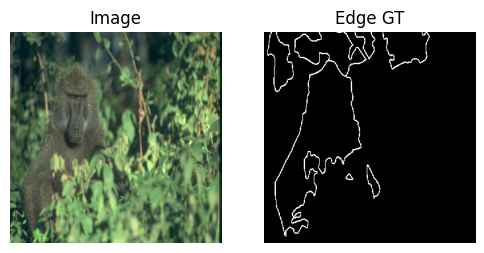

In [ ]:
import os, glob
import numpy as np
import scipy.io as sio
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class BSDS500Dataset(Dataset):
    def __init__(self, root, split="train", size=320):
        self.img_files = sorted(glob.glob(os.path.join(root, "images", split, "*.jpg")))
        self.gt_files  = sorted(glob.glob(os.path.join(root, "groundTruth", split, "*.mat")))
        self.size = size
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __len__(self): return len(self.img_files)

    def __getitem__(self, idx):
        # load image
        img = cv2.imread(self.img_files[idx])[:, :, ::-1]
        img = cv2.resize(img, (self.size, self.size))

        # load ground truth MAT file
        mat = sio.loadmat(self.gt_files[idx])
        gt_struct = mat["groundTruth"][0]

        # pick the first annotator's boundaries safely
        g = gt_struct[0][0] if isinstance(gt_struct[0], np.ndarray) else gt_struct[0]
        b = g["Boundaries"]
        if isinstance(b, np.ndarray) and b.size > 0:
            edge = b[0] if b.ndim == 1 else b[0, 0]
        else:
            edge = b
        edge = edge.astype(np.float32)
        edge = cv2.resize(edge, (self.size, self.size))
        edge = (edge > 0).astype(np.float32)

        x = self.normalize(self.to_tensor(img))
        y = torch.from_numpy(edge).unsqueeze(0)
        return x, y

# training dataset
train_ds = BSDS500Dataset("data", "train", size=320)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

# validation dataset
val_ds = BSDS500Dataset("data", "val", size=320)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True)

x_batch, y_batch = next(iter(train_loader))
print("Batch shapes:", x_batch.shape, y_batch.shape)

# visualize one sample
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(np.transpose(x_batch[0].numpy(), (1,2,0))*0.25+0.5); plt.axis('off'); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(y_batch[0,0], cmap='gray'); plt.axis('off'); plt.title("Edge GT")
plt.show()

Training Model with Checkpoints

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# EdgeUncertaintyModel
class EdgeUncertaintyModel(nn.Module):
    """
    Simple encoder + three heads:
      - mu: raw real-valued map (no sigmoid)
      - sigma2: positive variance (Softplus)
      - edge_logits: auxiliary logits for optional supervision
    Returns: (mu, sigma2, edge_logits)
    Shapes: (B,1,H,W) each
    """
    def __init__(self, in_ch=3, feat_ch=32):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_ch, feat_ch, 3, padding=1),
            nn.BatchNorm2d(feat_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(feat_ch, feat_ch, 3, padding=1),
            nn.BatchNorm2d(feat_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(feat_ch, feat_ch, 3, padding=1),
            nn.BatchNorm2d(feat_ch),
            nn.ReLU(inplace=True),
        )

        # Main heads
        self.mu_head = nn.Conv2d(feat_ch, 1, kernel_size=1)
        self.var_head = nn.Sequential(nn.Conv2d(feat_ch, 1, kernel_size=1),
                                      nn.Softplus())
        self.edge_head = nn.Conv2d(feat_ch, 1, kernel_size=1)

        # Auxiliary branch
        self.aux_backbone = nn.Sequential(
            nn.Conv2d(in_ch, feat_ch, 3, padding=1),
            nn.BatchNorm2d(feat_ch),
            nn.ReLU(inplace=True)
        )
        self.mu_aux = nn.Conv2d(feat_ch, 1, kernel_size=1)
        self.var_aux = nn.Sequential(nn.Conv2d(feat_ch, 1, kernel_size=1),
                                     nn.Softplus())
        self.edge_aux = nn.Conv2d(feat_ch, 1, kernel_size=1)

    def forward(self, x):
        # main branch
        f = self.backbone(x)
        mu = self.mu_head(f)
        sigma2 = self.var_head(f) + 1e-6
        edge_logits = self.edge_head(f)

        # auxiliary branch
        f_a = self.aux_backbone(x)
        mu_a = self.mu_aux(f_a)
        sigma2_a = self.var_aux(f_a) + 1e-6
        edge_logits_a = self.edge_aux(f_a)

        return mu, sigma2, edge_logits, mu_a, sigma2_a, edge_logits_a

# EdgeELBOLoss
class EdgeELBOLoss(nn.Module):
    """
    ELBO loss used in EDMB reproduction:
    Returns tuple: (elbo, wce, kl)
    """
    def __init__(self, phi=1.0, lambda_pos=1.1):
        super().__init__()
        self.phi = float(phi)
        self.lambda_pos = float(lambda_pos)
        # small epsilon for numerical stability in logs/sqrt
        self.eps = 1e-6

    def forward(self, mu, sigma2, edge_logits_or_none, y):
        # shapes
        B = y.size(0)
        total = float(y.numel())

        # sample from N(mu, sigma2) using reparameterization
        eps = torch.randn_like(mu)
        sample = mu + eps * torch.sqrt(sigma2 + self.eps)   # raw logits
        p = torch.sigmoid(sample)                           # in (0,1) probability

        # Weighted Binary Cross Entropy
        pos = (y == 1).float()
        neg = (y == 0).float()
        pos_count = pos.sum().clamp_min(1.0)
        neg_count = neg.sum().clamp_min(1.0)

        alpha = pos_count / total
        beta = self.lambda_pos * (neg_count / total)

        # compute log probabilities safely
        p = p.clamp(self.eps, 1.0 - self.eps)
        log_p = torch.log(p)
        log_1mp = torch.log(1.0 - p)

        wce = -(alpha * (pos * log_p).sum() + beta * (neg * log_1mp).sum()) / total

        # KL divergence per-pixel, averaged
        kl_map = 0.5 * (mu.pow(2) + sigma2 - torch.log(sigma2 + self.eps) - 1.0)
        kl = kl_map.sum() / total

        elbo = wce + self.phi * kl
        return elbo, wce, kl

def make_loss(phi=1.0, lambda_pos=1.1):
    return EdgeELBOLoss(phi=phi, lambda_pos=lambda_pos)

In [ ]:
x = torch.randn(1, 3, 320, 320)
model = EdgeUncertaintyModel(in_ch=3, feat_ch=32)
mu, sigma2, logits, mu_a, sigma2_a, logits_a = model(x)

print(mu.shape, sigma2.shape, logits.shape)
print(mu_a.shape, sigma2_a.shape, logits_a.shape)

torch.Size([1, 1, 320, 320]) torch.Size([1, 1, 320, 320]) torch.Size([1, 1, 320, 320])
torch.Size([1, 1, 320, 320]) torch.Size([1, 1, 320, 320]) torch.Size([1, 1, 320, 320])


In [ ]:
model = EdgeUncertaintyModel(in_ch=3, feat_ch=32).cuda()
criterion = EdgeELBOLoss(phi=1.0, lambda_pos=1.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
import torch.nn.functional as F

def weighted_bce(pred, target, pos_weight=1.1):
    # Weighted BCE used for the auxiliary head.
    pred = pred.clamp(1e-6, 1 - 1e-6)
    return F.binary_cross_entropy(pred, target, reduction='mean')

In [ ]:
import torch

def edge_accuracy(pred_logits, gt, threshold=0.5):
    # Computes pixel-level accuracy between predicted and ground truth edges.
    with torch.no_grad():
        probs = torch.sigmoid(pred_logits)
        preds = (probs > threshold).float()
        correct = (preds == gt).float().sum()
        total = gt.numel()
        return (correct / total).item() * 100.0  # percentage

In [ ]:
import os
from tqdm import tqdm

# hyper-parameters
alpha1 = 0.3
alpha2 = 0.4
num_epochs = 10
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

model = EdgeUncertaintyModel(in_ch=3, feat_ch=32).cuda()
criterion = EdgeELBOLoss(phi=1.0, lambda_pos=1.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Lists to store metrics
train_total_losses = []
train_main_losses = []
train_aux_losses = []
train_accuracies = []

val_total_losses = []
val_main_losses = []
val_aux_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_total, running_main, running_aux, running_acc = 0.0, 0.0, 0.0, 0.0

    for imgs, edges in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, edges = imgs.cuda(), edges.cuda()

        mu, sigma2, logits, mu_a, sigma2_a, logits_a = model(imgs)

        # main ELBO
        elbo_main, wce_main, kl_main = criterion(mu, sigma2, logits, edges)

        # auxiliary terms
        p_a = torch.sigmoid(logits_a)
        wce_aux = weighted_bce(p_a, edges)
        elbo_aux, wce_aux2, kl_aux = criterion(mu_a, sigma2_a, logits_a, edges)

        # total loss
        total_loss = elbo_main + alpha1 * wce_aux + alpha2 * elbo_aux

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # compute training accuracy (for main output)
        acc = edge_accuracy(logits, edges)
        running_total += total_loss.item()
        running_main += elbo_main.item()
        running_aux += elbo_aux.item()
        running_acc += acc

    avg_total = running_total / len(train_loader)
    avg_main = running_main / len(train_loader)
    avg_aux = running_aux / len(train_loader)
    avg_acc = running_acc / len(train_loader)

    # append to lists
    train_total_losses.append(avg_total)
    train_main_losses.append(avg_main)
    train_aux_losses.append(avg_aux)
    train_accuracies.append(avg_acc)

    print(f"Epoch {epoch}: total={avg_total:.4f}, mainELBO={avg_main:.4f}, auxELBO={avg_aux:.4f}, acc={avg_acc:.2f}%")

    # Validation Loop
    model.eval()
    val_running_total, val_running_main, val_running_aux, val_running_acc = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, edges in tqdm(val_loader, desc=f"Epoch {epoch} [Validation]"):
            imgs, edges = imgs.cuda(), edges.cuda()

            mu, sigma2, logits, mu_a, sigma2_a, logits_a = model(imgs)

            # main ELBO
            elbo_main, wce_main, kl_main = criterion(mu, sigma2, logits, edges)

            # auxiliary terms
            p_a = torch.sigmoid(logits_a)
            wce_aux = weighted_bce(p_a, edges)
            elbo_aux, wce_aux2, kl_aux = criterion(mu_a, sigma2_a, logits_a, edges)

            total_loss = elbo_main + alpha1 * wce_aux + alpha2 * elbo_aux

            acc = edge_accuracy(logits, edges)
            val_running_total += total_loss.item()
            val_running_main += elbo_main.item()
            val_running_aux += elbo_aux.item()
            val_running_acc += acc

    # --- compute average validation metrics ---
    val_avg_total = val_running_total / len(val_loader)
    val_avg_main = val_running_main / len(val_loader)
    val_avg_aux = val_running_aux / len(val_loader)
    val_avg_acc = val_running_acc / len(val_loader)

    val_total_losses.append(val_avg_total)
    val_main_losses.append(val_avg_main)
    val_aux_losses.append(val_avg_aux)
    val_accuracies.append(val_avg_acc)

    # checkpoint
    ckpt_path = os.path.join(ckpt_dir, f"epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }, ckpt_path)
    print(f"Saved checkpoint → {ckpt_path}")


Epoch 1: 100%|██████████| 100/100 [00:04<00:00, 23.85it/s]


Epoch 1: total=1.6084, mainELBO=1.1012, auxELBO=0.8146, acc=69.66%


Epoch 1 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.12it/s]


Saved checkpoint → checkpoints/epoch_1.pth


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 23.70it/s]


Epoch 2: total=1.3936, mainELBO=0.9247, auxELBO=0.7611, acc=75.68%


Epoch 2 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 26.86it/s]


Saved checkpoint → checkpoints/epoch_2.pth


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 24.05it/s]


Epoch 3: total=1.2793, mainELBO=0.8325, auxELBO=0.7468, acc=78.72%


Epoch 3 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.77it/s]


Saved checkpoint → checkpoints/epoch_3.pth


Epoch 4: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 4: total=1.2104, mainELBO=0.7798, auxELBO=0.7397, acc=80.29%


Epoch 4 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 30.84it/s]


Saved checkpoint → checkpoints/epoch_4.pth


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 22.45it/s]


Epoch 5: total=1.1679, mainELBO=0.7483, auxELBO=0.7366, acc=82.20%


Epoch 5 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.43it/s]


Saved checkpoint → checkpoints/epoch_5.pth


Epoch 6: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 6: total=1.1386, mainELBO=0.7296, auxELBO=0.7329, acc=83.35%


Epoch 6 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.90it/s]


Saved checkpoint → checkpoints/epoch_6.pth


Epoch 7: 100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


Epoch 7: total=1.1196, mainELBO=0.7198, auxELBO=0.7295, acc=84.94%


Epoch 7 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.44it/s]


Saved checkpoint → checkpoints/epoch_7.pth


Epoch 8: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 8: total=1.1059, mainELBO=0.7143, auxELBO=0.7270, acc=86.29%


Epoch 8 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 36.09it/s]


Saved checkpoint → checkpoints/epoch_8.pth


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 21.41it/s]


Epoch 9: total=1.0970, mainELBO=0.7124, auxELBO=0.7247, acc=87.02%


Epoch 9 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.35it/s]


Saved checkpoint → checkpoints/epoch_9.pth


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.46it/s]


Epoch 10: total=1.0891, mainELBO=0.7104, auxELBO=0.7240, acc=87.87%


Epoch 10 [Validation]: 100%|██████████| 50/50 [00:01<00:00, 37.79it/s]

Saved checkpoint → checkpoints/epoch_10.pth


To resume training later

In [ ]:
def load_checkpoint(path, model, optimizer=None):
    ckpt = torch.load(path, map_location='cuda')
    model.load_state_dict(ckpt['model_state'])
    if optimizer and 'optimizer_state' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer_state'])
    print(f"Loaded checkpoint from epoch {ckpt.get('epoch', '?')}")

In [ ]:
load_checkpoint("checkpoints/epoch_5.pth", model, optimizer)

Loaded checkpoint from epoch 5


Visualize Predictions

Loaded checkpoint from epoch 10


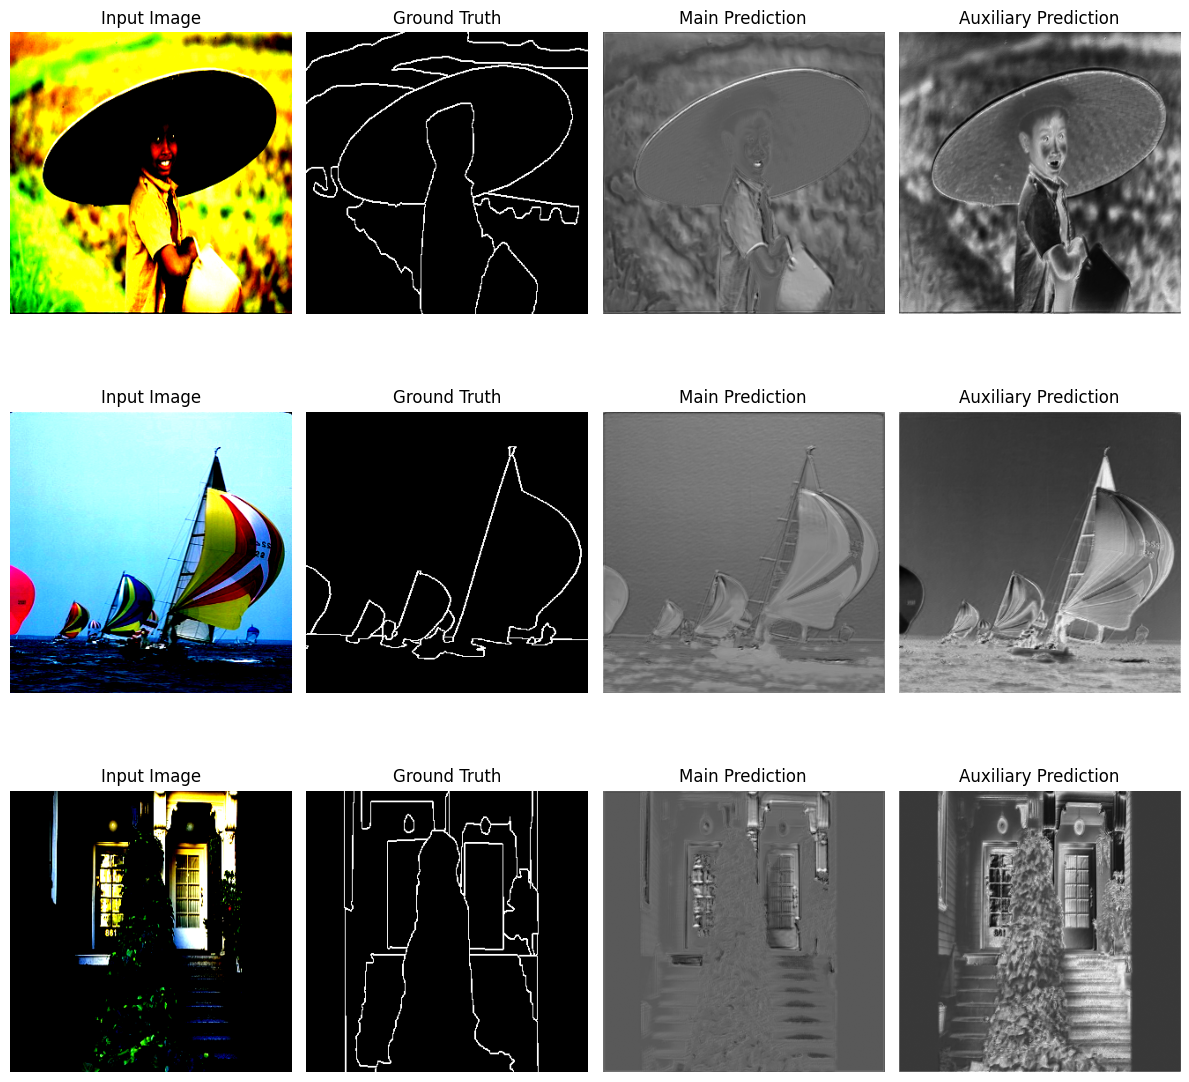

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

# Load best checkpoint
ckpt_path = "checkpoints/epoch_10.pth"  # change to the best epoch
load_checkpoint(ckpt_path, model, optimizer)
model.eval()

# Pick random samples
num_samples = 3
indices = random.sample(range(len(train_loader.dataset)), num_samples)

plt.figure(figsize=(12, 4 * num_samples))

for i, idx in enumerate(indices):
    img, edge = train_loader.dataset[idx]
    img_in = img.unsqueeze(0).cuda()  # (1,3,H,W)

    with torch.no_grad():
        mu, sigma2, logits, mu_a, sigma2_a, logits_a = model(img_in)
        pred_main = torch.sigmoid(logits).cpu().squeeze().numpy()
        pred_aux = torch.sigmoid(logits_a).cpu().squeeze().numpy()
        img_np = img.permute(1, 2, 0)
        gt = edge.squeeze()

    # Plot
    plt.subplot(num_samples, 4, 4*i + 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_samples, 4, 4*i + 2)
    plt.imshow(gt, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 4, 4*i + 3)
    plt.imshow(pred_main, cmap="gray")
    plt.title("Main Prediction")
    plt.axis("off")

    plt.subplot(num_samples, 4, 4*i + 4)
    plt.imshow(pred_aux, cmap="gray")
    plt.title("Auxiliary Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

Plot Training Metrics

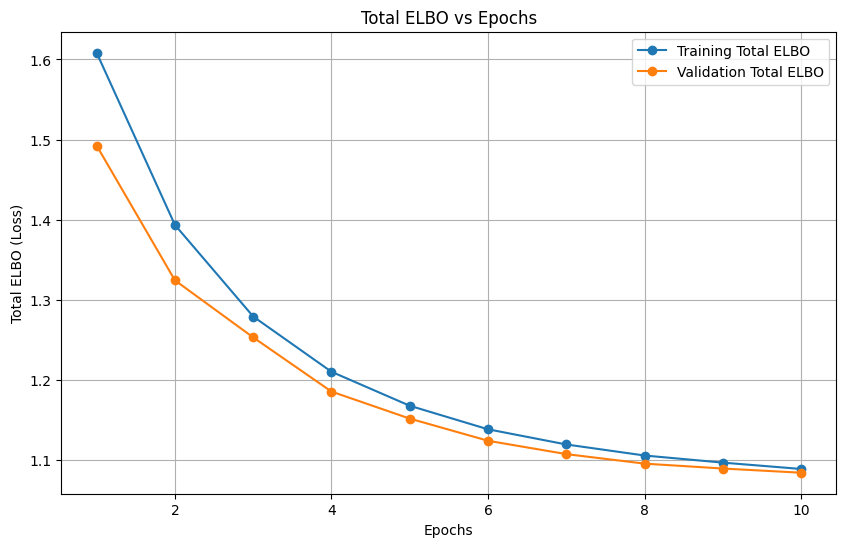

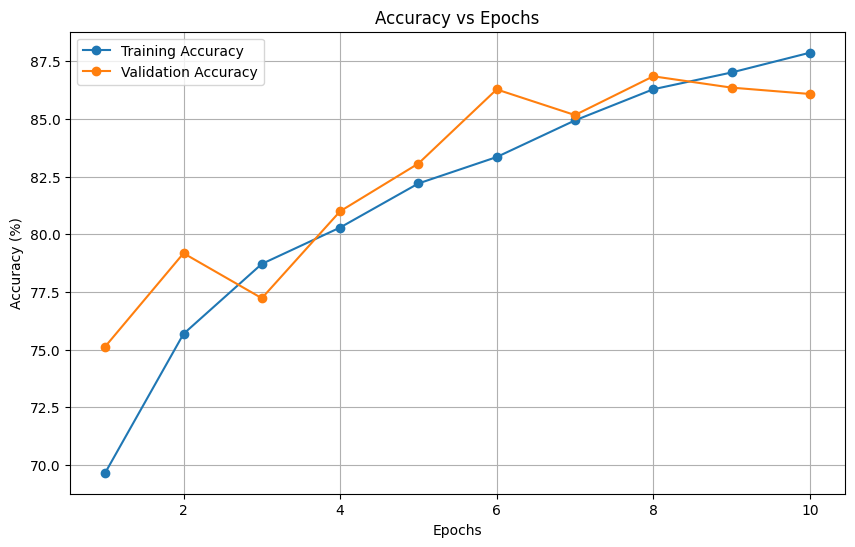

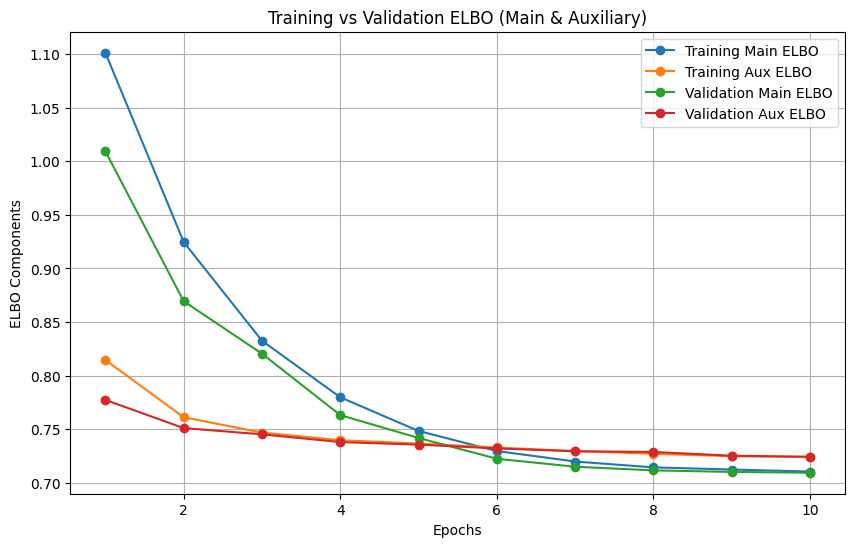

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_total_losses)+1)

# Total Loss vs Epochs
plt.figure(figsize=(10,6))
plt.plot(epochs, train_total_losses, label='Training Total ELBO', marker='o')
if val_total_losses:  # plot validation if available
    plt.plot(epochs, val_total_losses, label='Validation Total ELBO', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Total ELBO (Loss)')
plt.title('Total ELBO vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy vs Epochs
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
if val_accuracies:
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation ELBO
plt.figure(figsize=(10,6))
plt.plot(epochs, train_main_losses, label='Training Main ELBO', marker='o')
plt.plot(epochs, train_aux_losses, label='Training Aux ELBO', marker='o')
if val_main_losses and val_aux_losses:
    plt.plot(epochs, val_main_losses, label='Validation Main ELBO', marker='o')
    plt.plot(epochs, val_aux_losses, label='Validation Aux ELBO', marker='o')
plt.xlabel('Epochs')
plt.ylabel('ELBO Components')
plt.title('Training vs Validation ELBO (Main & Auxiliary)')
plt.legend()
plt.grid(True)
plt.show()